In [1]:
import numpy as np
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [2]:
import os
PATH = './out_2/'

#load .h5 images from local folder
def loadImageh5(name):
    with h5py.File(PATH+name, 'r') as img:
        return np.array(img['img'], dtype=np.single)

imgs = []
for i in os.listdir(PATH):
    imgs.append(loadImageh5(i))

In [3]:
#checking the shape of the .h5 images
input_shape = imgs[0].shape
print(input_shape)

(224, 150, 163)


In [4]:
#Extracting RGB from .h5 images (wavelenghts were arbitrarily chosen: R-793nm,
#G-331nm and B-163nm). We divide those values because RGB channels are 8 bit each 
RGBimg = []
for i in imgs:
    RGBimg.append(i[[793//8, 331//8, 163//8], :, :]) 

#printing out RGBimg shape to confirm we got an image with 3 channels instead of 224
print(RGBimg[0].shape)

(3, 150, 163)


In [5]:
from sklearn.model_selection import train_test_split

#splitting the train and test data (inputs(x) are RGB and outputs are .h5(hyperspectral))
train_x, test_x, train_y, test_y = train_test_split(RGBimg, imgs, test_size = 0.15, random_state = 69, shuffle = False)


In [6]:
#turns pictures to pixles and returns pixels 
def toPix(arr):
    pix = []
    information = []
    for im in arr:
        ch, w, h = im.shape
        information.append([ch, w, h])
        im2 = np.fliplr(np.moveaxis(im, 0, -1))
        pix.extend([px for row in im2 for px in row])
    return pix, information

train_x, trainX_information = toPix(train_x)
train_y, trainY_information = toPix(train_y)
test_x, testX_information = toPix(test_x)
test_y, testY_information = toPix(test_y)

#printing out to see how many pixels are in each set (input and output pixels)
print(len(train_x), len(train_y), len(test_x), len(test_y))

1083644 1083644 185658 185658


In [7]:
#making the model so that the input is RGB and the output is 224 channels
input = layers.Input(shape=(3))

decoded = layers.Dense(14, activation='relu')(input)
decoded = layers.Dense(37, activation='relu')(decoded)
decoded = layers.Dense(69, activation='relu')(decoded)
decoded = layers.Dense(102, activation='relu')(decoded)
decoded = layers.Dense(146, activation='relu')(decoded)
decoded = layers.Dense(224, activation='sigmoid')(decoded)

autoencoder = keras.Model(input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 14)                56        
                                                                 
 dense_1 (Dense)             (None, 37)                555       
                                                                 
 dense_2 (Dense)             (None, 69)                2622      
                                                                 
 dense_3 (Dense)             (None, 102)               7140      
                                                                 
 dense_4 (Dense)             (None, 146)               15038     
                                                                 
 dense_5 (Dense)             (None, 224)               32928 

In [8]:
#start training with 100 epochs
autoencoder.fit(np.array(train_x), np.array(train_y),
                epochs=100,
                batch_size=256,
                verbose = True,
                shuffle=False)

Epoch 1/100
4233/4233 [==============================] - 12s 3ms/step - loss: 0.0036
Epoch 2/100
4233/4233 [==============================] - 12s 3ms/step - loss: 0.0019
Epoch 3/100
4233/4233 [==============================] - 11s 3ms/step - loss: 0.0018
Epoch 4/100
4233/4233 [==============================] - 11s 3ms/step - loss: 0.0017
Epoch 5/100
4233/4233 [==============================] - 12s 3ms/step - loss: 0.0017
Epoch 6/100
4233/4233 [==============================] - 11s 3ms/step - loss: 0.0017
Epoch 7/100
4233/4233 [==============================] - 11s 3ms/step - loss: 0.0017
Epoch 8/100
4233/4233 [==============================] - 11s 3ms/step - loss: 0.0017
Epoch 9/100
4233/4233 [==============================] - 11s 3ms/step - loss: 0.0017
Epoch 10/100
4233/4233 [==============================] - 11s 3ms/step - loss: 0.0017
Epoch 11/100
4233/4233 [==============================] - 11s 3ms/step - loss: 0.0017
Epoch 12/100
4233/4233 [==============================] - 12s 3

4233/4233 [==============================] - 12s 3ms/step - loss: 0.0017
Epoch 97/100
4233/4233 [==============================] - 12s 3ms/step - loss: 0.0017
Epoch 98/100
4233/4233 [==============================] - 12s 3ms/step - loss: 0.0017
Epoch 99/100
4233/4233 [==============================] - 11s 3ms/step - loss: 0.0017
Epoch 100/100
4233/4233 [==============================] - 11s 3ms/step - loss: 0.0017


In [9]:
#evaluating the created model on test data
autoencoder.evaluate(np.array(test_x), 
               np.array(test_y), 
               batch_size=256,  
               verbose=2)

726/726 - 1s - loss: 0.0024 - 1s/epoch - 2ms/step


0.0024249653797596693

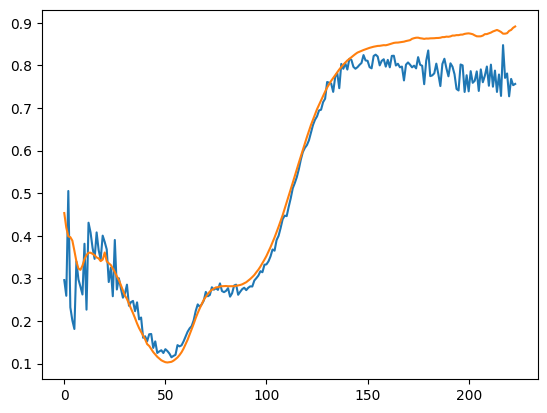

In [15]:
#plotting a graph: blue line - groung truth, orange - what the model predicted
plt.plot(range(224), test_y[5], label = "label") 
plt.plot(range(224), autoencoder(np.array([test_x[5]]))[0], label = "label")